In [1]:
# !pip install pykan

In [2]:
# !pip install moviepy

In [3]:
import torch
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import moviepy.video.io.ImageSequenceClip

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [4]:
def load_iris_dataset():
    # Load iris dataset
    iris = load_iris()
    data = iris.data
    target = iris.target

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    train_inputs = torch.empty(0, 4, device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, 4, device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels
    dataset['test_label'] = test_labels

    return dataset

iris_dataset = load_iris_dataset()

In [5]:
print("Train data shape: {}".format(iris_dataset['train_input'].shape))
print("Train target shape: {}".format(iris_dataset['train_label'].shape))
print("Test data shape: {}".format(iris_dataset['test_input'].shape))
print("Test target shape: {}".format(iris_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([120, 4])
Train target shape: torch.Size([120])
Test data shape: torch.Size([30, 4])
Test target shape: torch.Size([30])


In [6]:
def print_example_data_point(dataset):
    # Get column names from the dataset
    column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

    # Get a single data point from the dataset
    example_data_point = dataset['train_input'][0]

    # Get the corresponding target for the example data point
    example_target = int(dataset['train_label'][0])

    # Map numerical target to actual string label
    target_names = ['setosa', 'versicolor', 'virginica']
    actual_label = target_names[example_target]

    # Print column names and their corresponding values
    for i, column_name in enumerate(column_names):
        print(f"{column_name}: {example_data_point[i]}")

    # Print the target value and the actual string label
    print(f"Target (numerical): {example_target}")
    print(f"Actual Label: {actual_label}")

print_example_data_point(iris_dataset)

sepal_length: 5.800000190734863
sepal_width: 2.700000047683716
petal_length: 4.099999904632568
petal_width: 1.0
Target (numerical): 1
Actual Label: versicolor


checkpoint directory created: ./model
saving model version 0.0


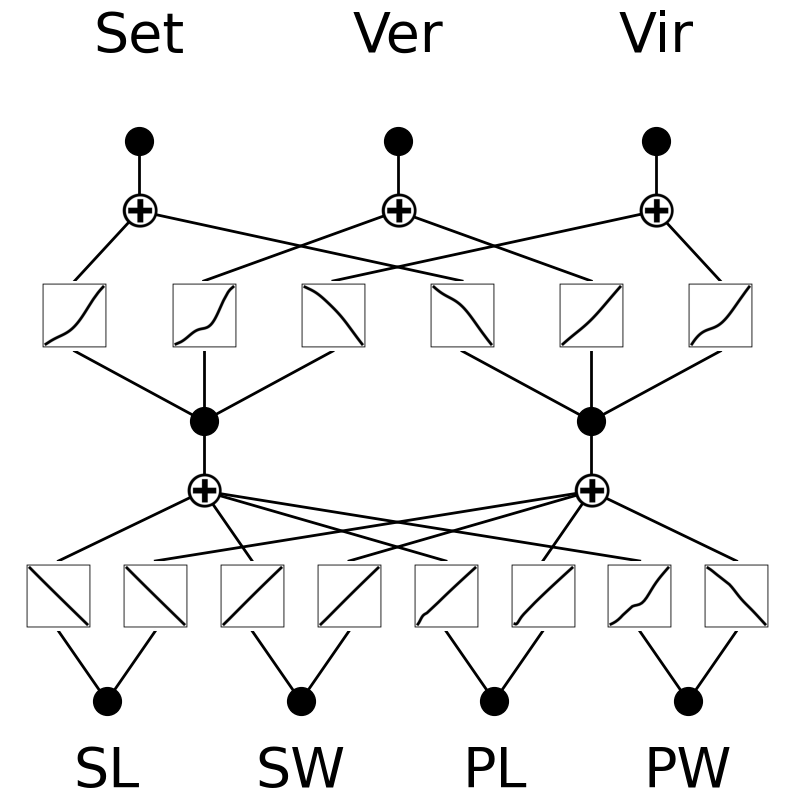

In [7]:
image_folder = 'video_img'

model = KAN(width=[4, 2, 3], grid=5, k=5, seed=0, device=device)

model(iris_dataset['train_input'])
model.plot(beta=100, scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

checkpoint directory created: ./model
saving model version 0.0


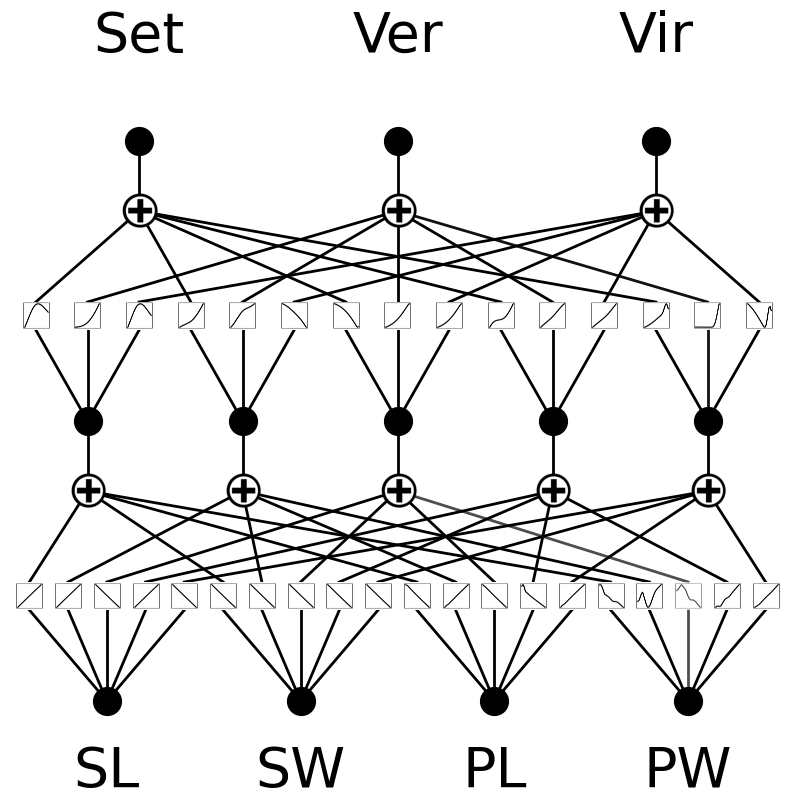

In [8]:
image_folder = 'video_img'

model = KAN(width=[4, 5, 3], grid=5, k=3, seed=0, device=device)

model(iris_dataset['train_input'])
model.plot(beta=100, scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [9]:
model

MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [10]:
def train_acc():
    return torch.mean((torch.argmax(model(iris_dataset['train_input']), dim=1) == iris_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(iris_dataset['test_input']), dim=1) == iris_dataset['test_label']).float())

results = model.fit(iris_dataset, 
                    opt="Adam", 
                    metrics=(train_acc, test_acc),
                    loss_fn=torch.nn.CrossEntropyLoss(), 
                    steps=100, 
                    lamb=0.01, 
                    lamb_entropy=10., 
                    save_fig=True, 
                    img_folder=image_folder)     

| train_loss: 2.14e-01 | test_loss: 1.09e-01 | reg: 7.67e+01 | : 100%|█| 100/100 [05:58<00:00,  3.59

saving model version 0.1


In [11]:
results['train_acc'][-1], results['test_acc'][-1]

(0.98333340883255, 1.0)

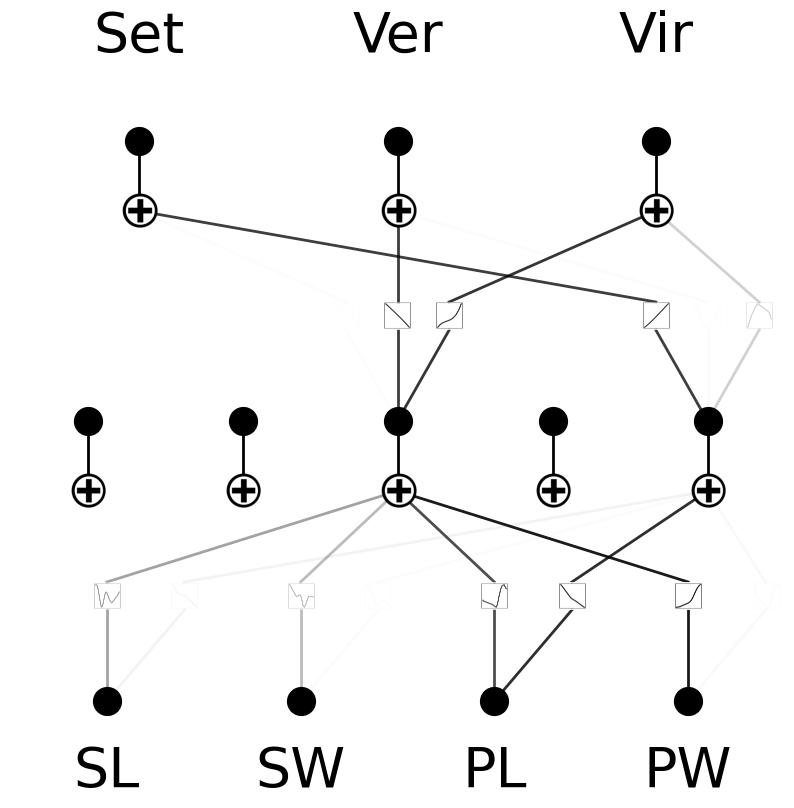

In [12]:
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [13]:
import numpy as np
import os

fps = 10
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)

In [14]:
clip.write_videofile('video.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


saving model version 0.2


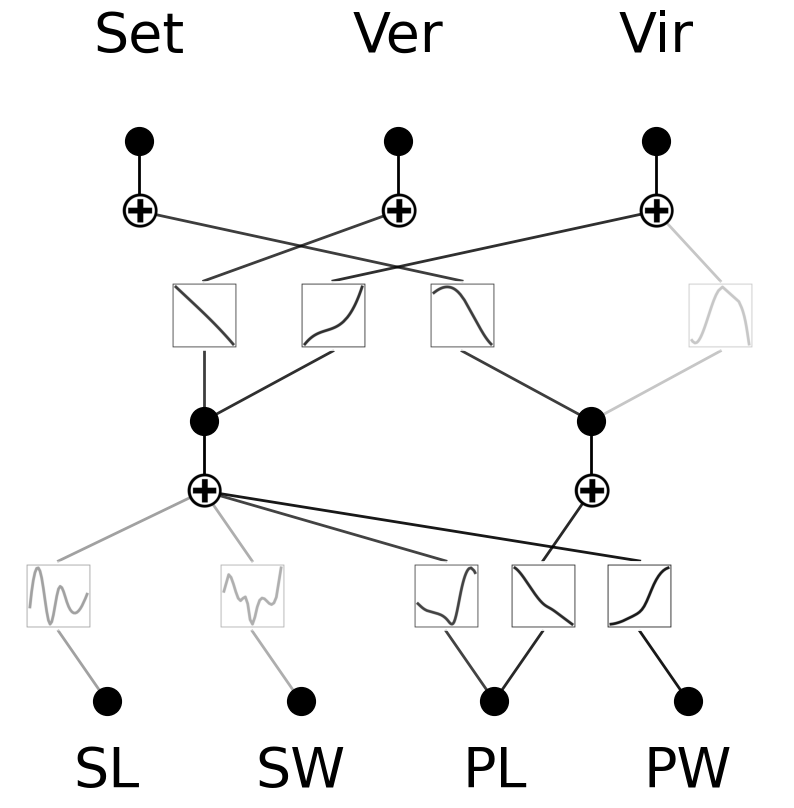

In [15]:
model = model.prune()
model(iris_dataset['train_input'])
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [16]:
# fine tune
results_1 = model.fit(iris_dataset, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=50, lamb=0.01, lamb_entropy=10.)
results_1['train_acc'][-1], results_1['test_acc'][-1]

| train_loss: 2.26e-01 | test_loss: 1.53e-01 | reg: 4.76e+01 | : 100%|█| 50/50 [00:01<00:00, 49.02it

saving model version 0.3


(0.98333340883255, 1.0)

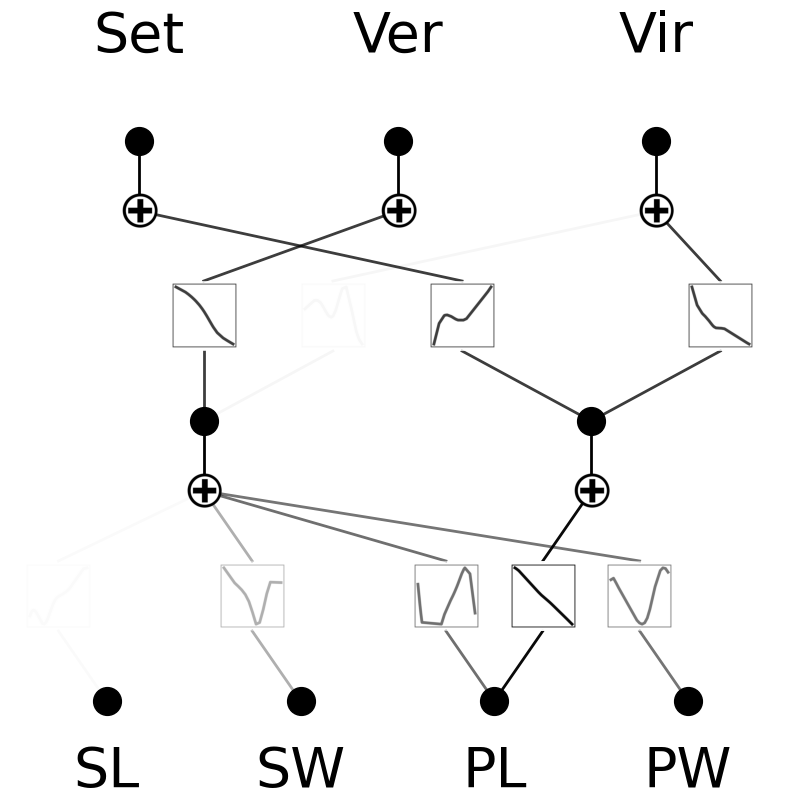

In [17]:
model.plot(scale=1, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [18]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.7496959567070007, c=1
fixing (0,0,1) with 0
fixing (0,1,0) with x, r2=0.017317693680524826, c=1
fixing (0,1,1) with 0
fixing (0,2,0) with x, r2=0.3087967038154602, c=1
fixing (0,2,1) with x, r2=0.9993628859519958, c=1
fixing (0,3,0) with sin, r2=0.9663426876068115, c=2
fixing (0,3,1) with 0
fixing (1,0,0) with 0
fixing (1,0,1) with x, r2=0.9819697737693787, c=1
fixing (1,0,2) with x, r2=0.2950221300125122, c=1
fixing (1,1,0) with x, r2=0.8554796576499939, c=1
fixing (1,1,1) with 0
fixing (1,1,2) with x, r2=0.8852550387382507, c=1
saving model version 0.4


In [19]:
model.symbolic_formula()

([19.6897200056758 - 6.60735460595944*x_3,
  -0.10435008834196*x_1 + 0.576678842519631*x_2 - 0.993702139359698*x_3 + 4.24524152727877*sin(2.75144004821777*x_4 + 4.8438401222229) + 2.85329980353677,
  -0.000217885064631285*x_1 + 0.00120411691902094*x_2 + 0.312285401685324*x_3 + 0.00886414893598714*sin(2.75144004821777*x_4 + 4.8438401222229) - 1.93050892701516],
 [x_1, x_2, x_3, x_4])

In [20]:
formula1, formula2, formula3 = model.symbolic_formula()[0]
formula1

19.6897200056758 - 6.60735460595944*x_3

In [21]:
formula2

-0.10435008834196*x_1 + 0.576678842519631*x_2 - 0.993702139359698*x_3 + 4.24524152727877*sin(2.75144004821777*x_4 + 4.8438401222229) + 2.85329980353677

In [22]:
formula3

-0.000217885064631285*x_1 + 0.00120411691902094*x_2 + 0.312285401685324*x_3 + 0.00886414893598714*sin(2.75144004821777*x_4 + 4.8438401222229) - 1.93050892701516

In [23]:
from sympy import simplify

simplify(formula1)

19.6897200056758 - 6.60735460595944*x_3

In [24]:
from torch import nn

class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 500)  # 4 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, 3)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [25]:
def load_iris_dataset():
    # Load California housing dataset
    iris = load_iris()
    data = iris.data
    target = iris.target

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=10, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=10, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_iris_dataset()

In [33]:
from torchsummary import summary
nn_model = IrisNet().to(device)
summary(nn_model, input_size=(4,), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]           2,500
              ReLU-2                  [-1, 500]               0
            Linear-3                    [-1, 3]           1,503
Total params: 4,003
Trainable params: 4,003
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01)

train_model(nn_model, train_loader, criterion, optimizer)

Epoch 1, Loss: 0.6758368611335754
Epoch 2, Loss: 1.0095069408416748
Epoch 3, Loss: 0.2976140081882477
Epoch 4, Loss: 0.2126428633928299
Epoch 5, Loss: 0.02830551005899906
Epoch 6, Loss: 0.04744954779744148
Epoch 7, Loss: 0.019761333242058754
Epoch 8, Loss: 0.02372291311621666
Epoch 9, Loss: 0.021295251324772835
Epoch 10, Loss: 0.04164799675345421
Epoch 11, Loss: 0.048946939408779144
Epoch 12, Loss: 0.06014292687177658
Epoch 13, Loss: 0.029045116156339645
Epoch 14, Loss: 0.3079148828983307
Epoch 15, Loss: 0.05680353194475174
Epoch 16, Loss: 0.011882488615810871
Epoch 17, Loss: 0.020459702238440514
Epoch 18, Loss: 0.5603184103965759
Epoch 19, Loss: 0.04157020524144173
Epoch 20, Loss: 0.00713952723890543
Epoch 21, Loss: 0.15375813841819763
Epoch 22, Loss: 0.12107400596141815
Epoch 23, Loss: 0.3521574139595032
Epoch 24, Loss: 0.000622966792434454
Epoch 25, Loss: 0.038145191967487335
Epoch 26, Loss: 0.005778922699391842
Epoch 27, Loss: 0.6893222332000732
Epoch 28, Loss: 0.14852537214756012


In [39]:
test_model(model, train_loader)

Accuracy: 95.0%


In [38]:
test_model(model, test_loader)

Accuracy: 100.0%


In [40]:
test_model(nn_model, train_loader)

Accuracy: 95.83333333333333%


In [41]:
test_model(nn_model, test_loader)

Accuracy: 96.66666666666667%


In [47]:
from time import time

def test_model_speed(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        s_time = time()
        for _ in range(100):
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    print(f'Collapsed Time: {time()-s_time:.2f}sec')

In [48]:
test_model_speed(model, test_loader)

Accuracy: 100.0%
Collapsed Time: 1.29sec


In [49]:
test_model_speed(nn_model, test_loader)

Accuracy: 96.66666666666667%
Collapsed Time: 0.09sec
